# Buffered pH Dynamics

Using checked-in code. Ref: Glaser _et al_ (2014) https://doi.org/10.1021/ed400808c

In [1]:
import projectpath

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.integrate
import scipy.optimize

from mosmo.knowledge import kb
from mosmo.knowledge.thermo import Thermodynamics
from mosmo.model import Molecule
from mosmo.sim.ph_dynamics import PROTON, ProtonationSequence, PhBuffer

jax.config.update('jax_enable_x64', True)
KB = kb.configure_kb()
thermo = Thermodynamics(p_h=7.3, p_mg=1.5, ionic_strength=0.25, temperature=298.15)

## From Glaser _et al_, malic acid equilibrium in water

In [2]:
malic = KB.get(KB.CHEBI, '30797')  # L-malate,  fully protonated
malate_m2 = KB.get(KB.CHEBI, '15589')  # L-malate 2-

# Not even ChEBI defines monoprotonated L-malate 1- (at either site). 
malate_m1 = Molecule(
    _id='mal.L.1-',
    name='(S)-malate(1-)',
    formula='C4H5O5',
    mass=133.08,
    charge=-1,
)

# malates = ProtonationSequence([malate_m2, malate_m1, malic], thermo.pkas(malate_m2))
malates = ProtonationSequence([malate_m2, malate_m1, malic], [5.10, 3.46])  # The values used in Glaser et al, not the same as eQuilibrator
print(malates)

# But ChEBI does define the full succinate series
succinates = ProtonationSequence(
    [KB.get(KB.CHEBI, '30031'), KB.get(KB.CHEBI, '30779'), KB.get(KB.CHEBI, '15741')],
    thermo.pkas(KB.get(KB.CHEBI, '15741')))
print(succinates)

ProtonationSequence(species=[[15589] (S)-malate(2-), [mal.L.1-] (S)-malate(1-), [30797] (S)-malic acid], p_kas=[5.1, 3.46])
ProtonationSequence(species=[[30031] succinate(2-), [30779] succinate(1-), [15741] succinic acid], p_kas=[5.69, 3.55])


In [3]:
buffer = PhBuffer([malates])
%time equilibrium = buffer.equilibrium(concs={malic: 0.1})
print(pd.Series(equilibrium))
print(f'Final pH: {-np.log10(equilibrium[PROTON]):.2f}')

CPU times: user 199 ms, sys: 11.5 ms, total: 210 ms
Wall time: 205 ms
[PROTON] proton              5.725546e-03
[HYDROXYL] hydroxyl group    1.746558e-12
[WATER] water                1.000000e+00
[15589] (S)-malate(2-)       7.921303e-06
[mal.L.1-] (S)-malate(1-)    5.709704e-03
[30797] (S)-malic acid       9.428237e-02
dtype: float64
Final pH: 2.24


### Titrate the mixture to the pKa of the less acidic site

In [4]:
%time equilibrium = buffer.titrate(concs={malic: 0.1}, pH=malates.p_kas[0])
print(pd.Series(equilibrium))
print(f'Final pH: {-np.log10(equilibrium[PROTON]):.2f}')

CPU times: user 303 ms, sys: 3.53 ms, total: 307 ms
Wall time: 304 ms
[PROTON] proton              7.943282e-06
[HYDROXYL] hydroxyl group    1.258925e-09
[WATER] water                1.000000e+00
[15589] (S)-malate(2-)       4.943377e-02
[mal.L.1-] (S)-malate(1-)    4.943377e-02
[30797] (S)-malic acid       1.132462e-03
dtype: float64
Final pH: 5.10


## Reproduce Glaser _et al_ Figure 4: pH as a function of:
- [L-mal(+0)]
- [L-mal(-1)]
- [L-mal(-1)] + 0.01 M [L-mal(+0)]

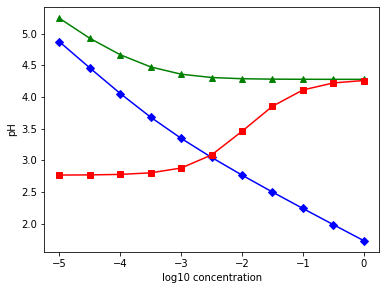

CPU times: user 5.52 s, sys: 177 ms, total: 5.7 s
Wall time: 5.46 s


In [5]:
%%time
conc_range = np.power(10, np.arange(-5, 0.5, 0.5))

def equilibrium_pH(buffer, concs):
    return -np.log10(buffer.equilibrium(concs)[PROTON])

dilute_malic_acid_pH = [equilibrium_pH(buffer, {malic: conc}) for conc in conc_range]
dilute_malate_pH = [equilibrium_pH(buffer, {malate_m1: conc}) for conc in conc_range]
malate_buffer_pH = [equilibrium_pH(buffer, {malic: 0.01, malate_m1: conc}) for conc in conc_range]

fig, ax = plt.subplots(1, 1, figsize=(6, 4.5))
ax.plot(np.log10(conc_range), dilute_malate_pH, label='malate', marker='^', color='g')
ax.plot(np.log10(conc_range), dilute_malic_acid_pH, label='malic acid', marker='D', color='b')
ax.plot(np.log10(conc_range), malate_buffer_pH, label='malate/malic acid buffer', marker='s', color='r')
ax.set_ylabel('pH')
ax.set_xlabel('log10 concentration')
plt.show()

## Protonation as a function of pH

In [ ]:
pH_range = np.arange(1.0, 8.0, 0.1)

%time species_by_pH = [buffer.titrate(concs={malic: 0.1}, pH=pH) for pH in pH_range]
df = pd.DataFrame(species_by_pH, index=pH_range)

protonation = [
    df[malates.species[1]] / (df[malates.species[0]] + df[malates.species[1]]),
    df[malates.species[2]] / (df[malates.species[1]] + df[malates.species[2]]),
]

fig, ax = plt.subplots(1, 1, figsize=(6, 4.5))
ax.plot(pH_range, protonation[0] * 100, label=f'$pK_a$ = {malates.p_kas[0]:.2f}')
ax.plot(pH_range, protonation[1] * 100, label=f'$pK_a$ = {malates.p_kas[1]:.2f}')
ax.set_xlabel('pH')
ax.set_ylabel('% Protonation')
ax.legend()
plt.show()

## Protonated species dynamics over time

In [ ]:
%time sim = buffer.simulate(concs={malic: 0.1}, pH=7.0, end=1e-6, step=1e-9)
pd.DataFrame(
    sim.y.T,
    index=sim.t * 1e6,
    columns=[mol.name for mol in buffer.species],
).plot(
    xlabel='t (μs)',
    ylabel='Concentration',
    logy=True,
)
plt.show()
print(f'Final pH: {-np.log10(sim.y[0][-1]):.2f}')